# Checking Files

In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('Datasets/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Datasets/Dataset_English\preprocessed_english_dataset.csv
Datasets/Dataset_English\jigsaw-toxic-comment-classification-challenge\sample_submission.csv.zip
Datasets/Dataset_English\jigsaw-toxic-comment-classification-challenge\test.csv.zip
Datasets/Dataset_English\jigsaw-toxic-comment-classification-challenge\test_labels.csv.zip
Datasets/Dataset_English\jigsaw-toxic-comment-classification-challenge\train.csv.zip
Datasets/Dataset_Maltese\maltese_dataset.csv
Datasets/Dataset_Maltese\test\test.csv
Datasets/Dataset_Maltese\train\train.csv
Datasets/MalteseTestSet\manual_toxic_detection_data.csv
Datasets/MalteseTestSet\synthetic_toxic_detection_data.csv
Datasets/MixedDataset\combined_data.csv
Datasets/MixedDataset\combined_data_backup.csv


In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2.3.0
True


In [4]:
train_data = pd.read_csv('../../Datasets/Dataset_Maltese/train/cross_validation/train.csv')
val_data = pd.read_csv('../../Datasets/Dataset_Maltese/train/cross_validation/val.csv')

# Fine-tuning mBERTu

In [30]:
from transformers import AutoTokenizer , AdamW , get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader , random_split

#train_data = subsampled_data

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("MLRS/mBERTu")

# Function to tokenize data
def tokenize_data(texts):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=128, return_tensors="pt")

# Tokenize the train and validation data
train_encodings = tokenize_data(train_data['comment'].tolist())
val_encodings = tokenize_data(val_data['comment'].tolist())

# Create labels tensors
train_labels = torch.tensor(train_data['isToxic'].values)
val_labels = torch.tensor(val_data['isToxic'].values)

# Create TensorDatasets for train and validation sets
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)

c:\Users\Family-PC\miniconda3\envs\thesis\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [31]:
# Create DataLoaders
batch_size = 32  # Adjust based on your GPU memory
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
    pin_memory=True
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8,
    pin_memory=True
)

In [32]:
from transformers import AutoModelForSequenceClassification
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import time

# Load model
model = AutoModelForSequenceClassification.from_pretrained("models/Experiments/Experiments_with_Cross_Validation/Experiment-1/mBERTu_ENGLISHDATASET/", num_labels=1)
model.to(device)

# Initialize optimizer, loss, and scaler
learning_rate = 2e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.BCEWithLogitsLoss()
scaler = torch.cuda.amp.GradScaler()

c:\Users\Family-PC\miniconda3\envs\thesis\lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [33]:
# Early stopping parameters
early_stopping_patience = 3
best_val_loss = float('inf')
best_epoch = 0
early_stopping_counter = 0

# Training parameters
num_epochs = 20
total_batches = len(train_dataloader)
print_every = total_batches // 10

# Training loop
model.train()
epoch_times = []

# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_f1_scores = []
val_f1_scores = []
train_precisions = []
val_precisions = []
train_recalls = []
val_recalls = []

# Scheduler: Linear warmup and decay
num_training_steps = num_epochs * len(train_dataloader)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Create directory to save the best model
model_save_dir = '../../temp/'
os.makedirs(model_save_dir, exist_ok=True)
best_model_path = os.path.join(model_save_dir, 'best_model.pth')

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    running_loss = 0.0
    all_predictions = []
    all_targets = []

    for batch_idx, (input_ids, attention_mask, target) in enumerate(train_dataloader):
        input_ids, attention_mask, target = input_ids.to(device), attention_mask.to(device), target.to(device)
        
        target = target.unsqueeze(1).float()
        optimizer.zero_grad()
        
        with autocast():
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, target)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        running_loss += loss.item()

        preds = torch.sigmoid(outputs.logits).detach().cpu().numpy()
        preds = (preds > 0.5).astype(int)
        all_predictions.extend(preds)
        all_targets.extend(target.detach().cpu().numpy())

        if batch_idx % print_every == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx+1}/{total_batches}: Loss: {loss.item():.4f}")

    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)

    epoch_loss = running_loss / total_batches
    epoch_accuracy = accuracy_score(np.vstack(all_predictions), np.vstack(all_targets))
    epoch_f1 = f1_score(np.vstack(all_predictions), np.vstack(all_targets), average='weighted')
    epoch_precision = precision_score(np.vstack(all_predictions), np.vstack(all_targets), average='weighted')
    epoch_recall = recall_score(np.vstack(all_predictions), np.vstack(all_targets), average='weighted')

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    train_f1_scores.append(epoch_f1)
    train_precisions.append(epoch_precision)
    train_recalls.append(epoch_recall)

    # Validation step
    model.eval()
    val_loss = 0.0
    val_predictions = []
    val_targets = []

    with torch.no_grad():
        for input_ids, attention_mask, target in val_dataloader:
            input_ids, attention_mask, target = input_ids.to(device), attention_mask.to(device), target.to(device)

            target = target.unsqueeze(1).float()

            with autocast():
                outputs = model(input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.logits, target)

            val_loss += loss.item()

            preds = torch.sigmoid(outputs.logits).detach().cpu().numpy()
            preds = (preds > 0.5).astype(int)
            val_predictions.extend(preds)
            val_targets.extend(target.detach().cpu().numpy())

    val_loss /= len(val_dataloader)
    val_accuracy = accuracy_score(np.vstack(val_predictions), np.vstack(val_targets))
    val_f1 = f1_score(np.vstack(val_predictions), np.vstack(val_targets), average='weighted')
    val_precision = precision_score(np.vstack(val_predictions), np.vstack(val_targets), average='weighted')
    val_recall = recall_score(np.vstack(val_predictions), np.vstack(val_targets), average='weighted')

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        early_stopping_counter = 0
        # Save the best model
        torch.save(model.state_dict(), best_model_path)
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

    # Switch back to training mode
    model.train()

    avg_epoch_time = sum(epoch_times) / len(epoch_times)
    estimated_total_time = avg_epoch_time * num_epochs
    remaining_time = estimated_total_time - sum(epoch_times)

    print(f"Epoch {epoch+1} completed in {epoch_time:.2f}s: Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, F1 Score: {epoch_f1:.4f}, Precision: {epoch_precision:.4f}, Recall: {epoch_recall:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation F1 Score: {val_f1:.4f}, Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}")
    print(f"Estimated total training time: {estimated_total_time:.2f}s")
    print(f"Estimated remaining time: {remaining_time:.2f}s")

print(f"Best epoch: {best_epoch + 1}, Best validation loss: {best_val_loss:.4f}")
print("Training completed.")

Epoch 1, Batch 1/110: Loss: 0.7058
Epoch 1, Batch 12/110: Loss: 0.4940
Epoch 1, Batch 23/110: Loss: 0.5366
Epoch 1, Batch 34/110: Loss: 0.3573
Epoch 1, Batch 45/110: Loss: 0.3012
Epoch 1, Batch 56/110: Loss: 0.3834
Epoch 1, Batch 67/110: Loss: 0.4732
Epoch 1, Batch 78/110: Loss: 0.2581
Epoch 1, Batch 89/110: Loss: 0.6934
Epoch 1, Batch 100/110: Loss: 0.4416
Epoch 1 completed in 55.08s: Loss: 0.4352, Accuracy: 0.7961, F1 Score: 0.7995, Precision: 0.8089, Recall: 0.7961
Validation Loss: 0.3467, Validation Accuracy: 0.8307, Validation F1 Score: 0.8349, Validation Precision: 0.8488, Validation Recall: 0.8307
Estimated total training time: 1101.54s
Estimated remaining time: 1046.46s
Epoch 2, Batch 1/110: Loss: 0.4292
Epoch 2, Batch 12/110: Loss: 0.3377
Epoch 2, Batch 23/110: Loss: 0.3269
Epoch 2, Batch 34/110: Loss: 0.2183
Epoch 2, Batch 45/110: Loss: 0.2203
Epoch 2, Batch 56/110: Loss: 0.4515
Epoch 2, Batch 67/110: Loss: 0.2095
Epoch 2, Batch 78/110: Loss: 0.1633
Epoch 2, Batch 89/110: Los

In [34]:
import csv

# Save the trained model
model_save_dir = 'models/Experiments/Experiments_with_Cross_Validation/Experiment-2/mBERTu_FINETUNE/'
os.makedirs(model_save_dir, exist_ok=True)
model.save_pretrained(model_save_dir)

# Save metrics to a CSV file
metrics_dict = {
    'Epoch': list(range(1, epoch + 2)),
    'Train Loss': train_losses,
    'Train Accuracy': train_accuracies,
    'Train F1 Score': train_f1_scores,
    'Train Precision': train_precisions,
    'Train Recall': train_recalls,
    'Val Loss': val_losses,
    'Val Accuracy': val_accuracies,
    'Val F1 Score': val_f1_scores,
    'Val Precision': val_precisions,
    'Val Recall': val_recalls
}

metrics_filename = os.path.join(model_save_dir, 'metrics.csv')
with open(metrics_filename, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=metrics_dict.keys())
    writer.writeheader()
    for row_idx in range(len(train_losses)):
        writer.writerow({key: metrics_dict[key][row_idx] for key in metrics_dict.keys()})

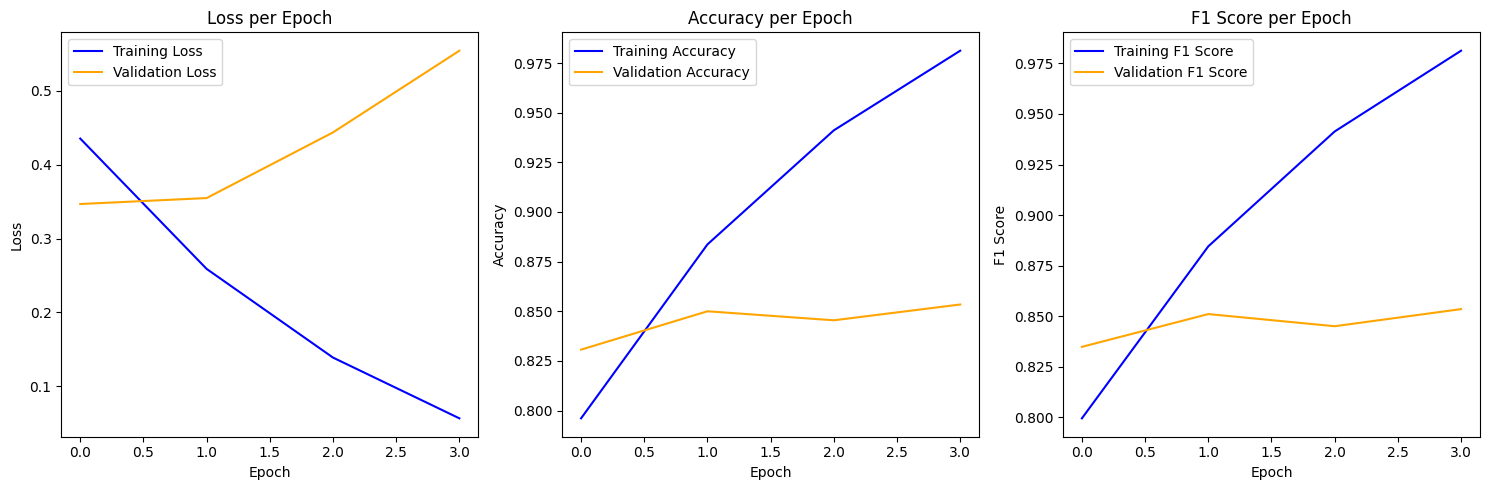

Results and graphs saved.


In [35]:
import matplotlib.pyplot as plt

# Plotting training and validation metrics
plt.figure(figsize=(15, 5))

# Plotting training and validation loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation F1 score
plt.subplot(1, 3, 3)
plt.plot(train_f1_scores, label='Training F1 Score', color='blue')
plt.plot(val_f1_scores, label='Validation F1 Score', color='orange')
plt.title('F1 Score per Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()

# Save and show the plot
graphs_save_path = os.path.join(model_save_dir, 'training_graphs.png')
plt.savefig(graphs_save_path)
plt.show()

print("Results and graphs saved.")

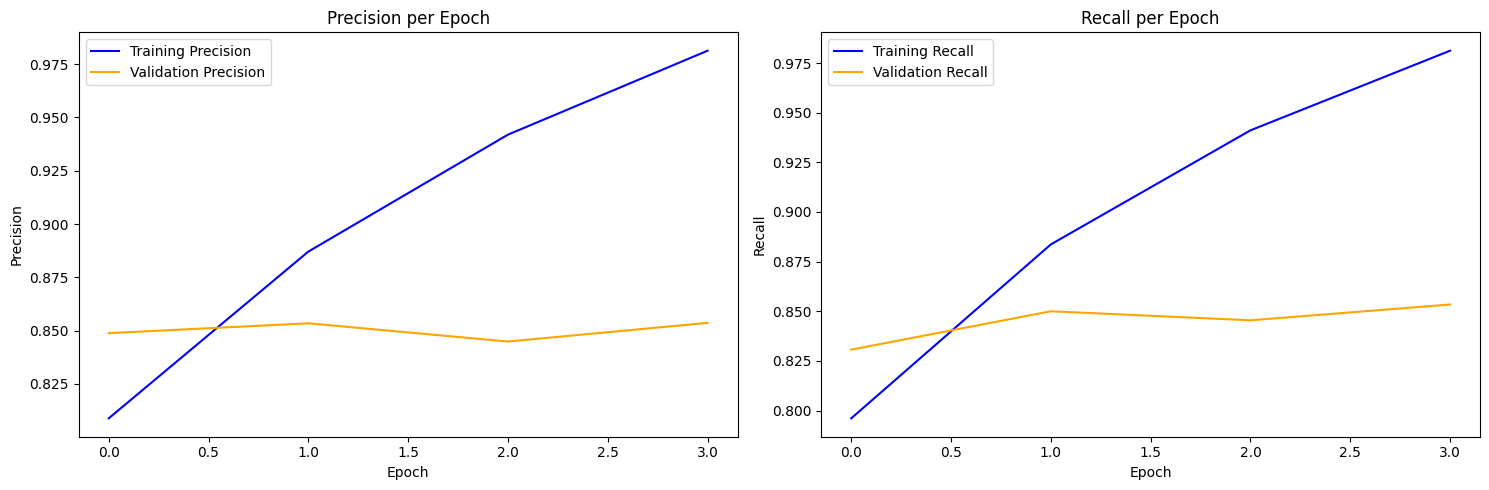

Precision and Recall graphs saved.


In [36]:
# Plotting training and validation precision and recall
plt.figure(figsize=(15, 5))

# Plotting training and validation precision
plt.subplot(1, 2, 1)
plt.plot(train_precisions, label='Training Precision', color='blue')
plt.plot(val_precisions, label='Validation Precision', color='orange')
plt.title('Precision per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Plotting training and validation recall
plt.subplot(1, 2, 2)
plt.plot(train_recalls, label='Training Recall', color='blue')
plt.plot(val_recalls, label='Validation Recall', color='orange')
plt.title('Recall per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()

# Save and show the plot
precision_recall_save_path = os.path.join(model_save_dir, 'precision_recall_graphs.png')
plt.savefig(precision_recall_save_path)
plt.show()

print("Precision and Recall graphs saved.")


# Fine-tuning BERT

In [12]:
from transformers import BertTokenizer , AdamW , get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader , random_split

#train_data = subsampled_data

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Function to tokenize data
def tokenize_data(texts):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=128, return_tensors="pt")

# Tokenize the train and validation data
train_encodings = tokenize_data(train_data['comment'].tolist())
val_encodings = tokenize_data(val_data['comment'].tolist())

# Create labels tensors
train_labels = torch.tensor(train_data['isToxic'].values)
val_labels = torch.tensor(val_data['isToxic'].values)

# Create TensorDatasets for train and validation sets
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)

c:\Users\Family-PC\miniconda3\envs\thesis\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [13]:
# Create DataLoaders
batch_size = 32  # Adjust based on your GPU memory
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
    pin_memory=True
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8,
    pin_memory=True
)

In [14]:
from transformers import BertForSequenceClassification
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import time

# Load model
model = BertForSequenceClassification.from_pretrained("models/Experiments/Experiments_with_Cross_Validation/Experiment-1/BERT_ENGLISHDATASET", num_labels=1)
model.to(device)

# Initialize optimizer, loss, and scaler
learning_rate = 2e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.BCEWithLogitsLoss()
scaler = torch.cuda.amp.GradScaler()

c:\Users\Family-PC\miniconda3\envs\thesis\lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
# Early stopping parameters
early_stopping_patience = 3
best_val_loss = float('inf')
best_epoch = 0
early_stopping_counter = 0

# Training parameters
num_epochs = 20
total_batches = len(train_dataloader)
print_every = total_batches // 10

# Training loop
model.train()
epoch_times = []

# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_f1_scores = []
val_f1_scores = []
train_precisions = []
val_precisions = []
train_recalls = []
val_recalls = []

# Scheduler: Linear warmup and decay
num_training_steps = num_epochs * len(train_dataloader)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Create directory to save the best model
model_save_dir = '../../temp/'
os.makedirs(model_save_dir, exist_ok=True)
best_model_path = os.path.join(model_save_dir, 'best_model.pth')

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    running_loss = 0.0
    all_predictions = []
    all_targets = []

    for batch_idx, (input_ids, attention_mask, target) in enumerate(train_dataloader):
        input_ids, attention_mask, target = input_ids.to(device), attention_mask.to(device), target.to(device)
        
        target = target.unsqueeze(1).float()
        optimizer.zero_grad()
        
        with autocast():
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, target)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        running_loss += loss.item()

        preds = torch.sigmoid(outputs.logits).detach().cpu().numpy()
        preds = (preds > 0.5).astype(int)
        all_predictions.extend(preds)
        all_targets.extend(target.detach().cpu().numpy())

        if batch_idx % print_every == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx+1}/{total_batches}: Loss: {loss.item():.4f}")

    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)

    epoch_loss = running_loss / total_batches
    epoch_accuracy = accuracy_score(np.vstack(all_predictions), np.vstack(all_targets))
    epoch_f1 = f1_score(np.vstack(all_predictions), np.vstack(all_targets), average='weighted')
    epoch_precision = precision_score(np.vstack(all_predictions), np.vstack(all_targets), average='weighted')
    epoch_recall = recall_score(np.vstack(all_predictions), np.vstack(all_targets), average='weighted')

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    train_f1_scores.append(epoch_f1)
    train_precisions.append(epoch_precision)
    train_recalls.append(epoch_recall)

    # Validation step
    model.eval()
    val_loss = 0.0
    val_predictions = []
    val_targets = []

    with torch.no_grad():
        for input_ids, attention_mask, target in val_dataloader:
            input_ids, attention_mask, target = input_ids.to(device), attention_mask.to(device), target.to(device)

            target = target.unsqueeze(1).float()

            with autocast():
                outputs = model(input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.logits, target)

            val_loss += loss.item()

            preds = torch.sigmoid(outputs.logits).detach().cpu().numpy()
            preds = (preds > 0.5).astype(int)
            val_predictions.extend(preds)
            val_targets.extend(target.detach().cpu().numpy())

    val_loss /= len(val_dataloader)
    val_accuracy = accuracy_score(np.vstack(val_predictions), np.vstack(val_targets))
    val_f1 = f1_score(np.vstack(val_predictions), np.vstack(val_targets), average='weighted')
    val_precision = precision_score(np.vstack(val_predictions), np.vstack(val_targets), average='weighted')
    val_recall = recall_score(np.vstack(val_predictions), np.vstack(val_targets), average='weighted')

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        early_stopping_counter = 0
        # Save the best model
        torch.save(model.state_dict(), best_model_path)
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

    # Switch back to training mode
    model.train()

    avg_epoch_time = sum(epoch_times) / len(epoch_times)
    estimated_total_time = avg_epoch_time * num_epochs
    remaining_time = estimated_total_time - sum(epoch_times)

    print(f"Epoch {epoch+1} completed in {epoch_time:.2f}s: Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, F1 Score: {epoch_f1:.4f}, Precision: {epoch_precision:.4f}, Recall: {epoch_recall:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation F1 Score: {val_f1:.4f}, Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}")
    print(f"Estimated total training time: {estimated_total_time:.2f}s")
    print(f"Estimated remaining time: {remaining_time:.2f}s")

print(f"Best epoch: {best_epoch + 1}, Best validation loss: {best_val_loss:.4f}")
print("Training completed.")

Epoch 1, Batch 1/110: Loss: 1.6458
Epoch 1, Batch 12/110: Loss: 0.6179
Epoch 1, Batch 23/110: Loss: 0.5078
Epoch 1, Batch 34/110: Loss: 0.4123
Epoch 1, Batch 45/110: Loss: 0.3613
Epoch 1, Batch 56/110: Loss: 0.5384
Epoch 1, Batch 67/110: Loss: 0.4491
Epoch 1, Batch 78/110: Loss: 0.5876
Epoch 1, Batch 89/110: Loss: 0.4616
Epoch 1, Batch 100/110: Loss: 0.5402
Epoch 1 completed in 26.18s: Loss: 0.5230, Accuracy: 0.7622, F1 Score: 0.7684, Precision: 0.7845, Recall: 0.7622
Validation Loss: 0.3956, Validation Accuracy: 0.8034, Validation F1 Score: 0.8108, Validation Precision: 0.8410, Validation Recall: 0.8034
Estimated total training time: 523.53s
Estimated remaining time: 497.36s
Epoch 2, Batch 1/110: Loss: 0.3845
Epoch 2, Batch 12/110: Loss: 0.4304
Epoch 2, Batch 23/110: Loss: 0.2312
Epoch 2, Batch 34/110: Loss: 0.3236
Epoch 2, Batch 45/110: Loss: 0.4378
Epoch 2, Batch 56/110: Loss: 0.2521
Epoch 2, Batch 67/110: Loss: 0.2607
Epoch 2, Batch 78/110: Loss: 0.3637
Epoch 2, Batch 89/110: Loss:

In [16]:
import csv

# Save the trained model
model_save_dir = 'models/Experiments/Experiments_with_Cross_Validation/Experiment-2/BERT_FINETUNE/'
os.makedirs(model_save_dir, exist_ok=True)
model.save_pretrained(model_save_dir)

# Save metrics to a CSV file
metrics_dict = {
    'Epoch': list(range(1, epoch + 2)),
    'Train Loss': train_losses,
    'Train Accuracy': train_accuracies,
    'Train F1 Score': train_f1_scores,
    'Train Precision': train_precisions,
    'Train Recall': train_recalls,
    'Val Loss': val_losses,
    'Val Accuracy': val_accuracies,
    'Val F1 Score': val_f1_scores,
    'Val Precision': val_precisions,
    'Val Recall': val_recalls
}

metrics_filename = os.path.join(model_save_dir, 'metrics.csv')
with open(metrics_filename, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=metrics_dict.keys())
    writer.writeheader()
    for row_idx in range(len(train_losses)):
        writer.writerow({key: metrics_dict[key][row_idx] for key in metrics_dict.keys()})

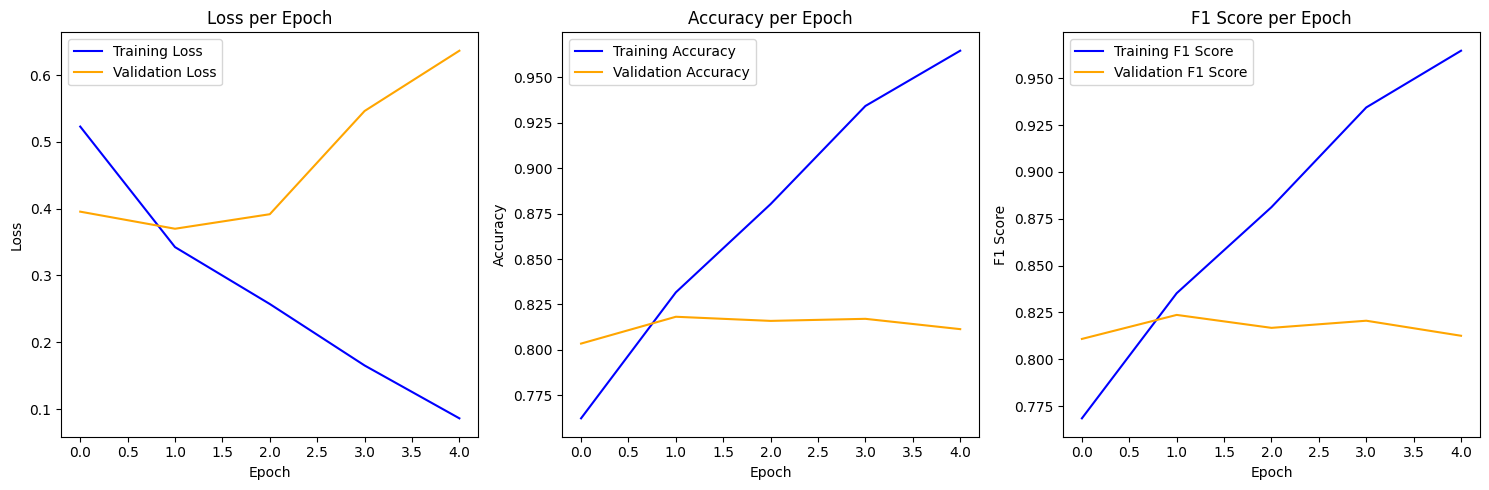

Results and graphs saved.


In [17]:
import matplotlib.pyplot as plt

# Plotting training and validation metrics
plt.figure(figsize=(15, 5))

# Plotting training and validation loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation F1 score
plt.subplot(1, 3, 3)
plt.plot(train_f1_scores, label='Training F1 Score', color='blue')
plt.plot(val_f1_scores, label='Validation F1 Score', color='orange')
plt.title('F1 Score per Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()

# Save and show the plot
graphs_save_path = os.path.join(model_save_dir, 'training_graphs.png')
plt.savefig(graphs_save_path)
plt.show()

print("Results and graphs saved.")

# Fine-tuning XLM-R

In [18]:
from transformers import XLMRobertaTokenizer , AdamW , get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader , random_split

#train_data = subsampled_data

# Load tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

# Function to tokenize data
def tokenize_data(texts):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=128, return_tensors="pt")

# Tokenize the train and validation data
train_encodings = tokenize_data(train_data['comment'].tolist())
val_encodings = tokenize_data(val_data['comment'].tolist())

# Create labels tensors
train_labels = torch.tensor(train_data['isToxic'].values)
val_labels = torch.tensor(val_data['isToxic'].values)

# Create TensorDatasets for train and validation sets
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)

c:\Users\Family-PC\miniconda3\envs\thesis\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [19]:
# Create DataLoaders
batch_size = 16  # Adjust based on your GPU memory
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
    pin_memory=True
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8,
    pin_memory=True
)

In [20]:
from transformers import XLMRobertaForSequenceClassification
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import time

# Load model
model = XLMRobertaForSequenceClassification.from_pretrained("models/Experiments/Experiments_with_Cross_Validation/Experiment-1/XLMR_ENGLISHDATASET", num_labels=1)
model.to(device)

# Initialize optimizer, loss, and scaler
learning_rate = 2e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.BCEWithLogitsLoss()
scaler = torch.cuda.amp.GradScaler()

c:\Users\Family-PC\miniconda3\envs\thesis\lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
# Early stopping parameters
early_stopping_patience = 3
best_val_loss = float('inf')
best_epoch = 0
early_stopping_counter = 0

# Training parameters
num_epochs = 20
total_batches = len(train_dataloader)
print_every = total_batches // 10

# Training loop
model.train()
epoch_times = []

# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_f1_scores = []
val_f1_scores = []
train_precisions = []
val_precisions = []
train_recalls = []
val_recalls = []

# Scheduler: Linear warmup and decay
num_training_steps = num_epochs * len(train_dataloader)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Create directory to save the best model
model_save_dir = '../../temp/'
os.makedirs(model_save_dir, exist_ok=True)
best_model_path = os.path.join(model_save_dir, 'best_model.pth')

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    running_loss = 0.0
    all_predictions = []
    all_targets = []

    for batch_idx, (input_ids, attention_mask, target) in enumerate(train_dataloader):
        input_ids, attention_mask, target = input_ids.to(device), attention_mask.to(device), target.to(device)
        
        target = target.unsqueeze(1).float()
        optimizer.zero_grad()
        
        with autocast():
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, target)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        running_loss += loss.item()

        preds = torch.sigmoid(outputs.logits).detach().cpu().numpy()
        preds = (preds > 0.5).astype(int)
        all_predictions.extend(preds)
        all_targets.extend(target.detach().cpu().numpy())

        if batch_idx % print_every == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx+1}/{total_batches}: Loss: {loss.item():.4f}")

    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)

    epoch_loss = running_loss / total_batches
    epoch_accuracy = accuracy_score(np.vstack(all_predictions), np.vstack(all_targets))
    epoch_f1 = f1_score(np.vstack(all_predictions), np.vstack(all_targets), average='weighted')
    epoch_precision = precision_score(np.vstack(all_predictions), np.vstack(all_targets), average='weighted')
    epoch_recall = recall_score(np.vstack(all_predictions), np.vstack(all_targets), average='weighted')

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    train_f1_scores.append(epoch_f1)
    train_precisions.append(epoch_precision)
    train_recalls.append(epoch_recall)

    # Validation step
    model.eval()
    val_loss = 0.0
    val_predictions = []
    val_targets = []

    with torch.no_grad():
        for input_ids, attention_mask, target in val_dataloader:
            input_ids, attention_mask, target = input_ids.to(device), attention_mask.to(device), target.to(device)

            target = target.unsqueeze(1).float()

            with autocast():
                outputs = model(input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.logits, target)

            val_loss += loss.item()

            preds = torch.sigmoid(outputs.logits).detach().cpu().numpy()
            preds = (preds > 0.5).astype(int)
            val_predictions.extend(preds)
            val_targets.extend(target.detach().cpu().numpy())

    val_loss /= len(val_dataloader)
    val_accuracy = accuracy_score(np.vstack(val_predictions), np.vstack(val_targets))
    val_f1 = f1_score(np.vstack(val_predictions), np.vstack(val_targets), average='weighted')
    val_precision = precision_score(np.vstack(val_predictions), np.vstack(val_targets), average='weighted')
    val_recall = recall_score(np.vstack(val_predictions), np.vstack(val_targets), average='weighted')

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        early_stopping_counter = 0
        # Save the best model
        torch.save(model.state_dict(), best_model_path)
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

    # Switch back to training mode
    model.train()

    avg_epoch_time = sum(epoch_times) / len(epoch_times)
    estimated_total_time = avg_epoch_time * num_epochs
    remaining_time = estimated_total_time - sum(epoch_times)

    print(f"Epoch {epoch+1} completed in {epoch_time:.2f}s: Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, F1 Score: {epoch_f1:.4f}, Precision: {epoch_precision:.4f}, Recall: {epoch_recall:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation F1 Score: {val_f1:.4f}, Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}")
    print(f"Estimated total training time: {estimated_total_time:.2f}s")
    print(f"Estimated remaining time: {remaining_time:.2f}s")

print(f"Best epoch: {best_epoch + 1}, Best validation loss: {best_val_loss:.4f}")
print("Training completed.")

Epoch 1, Batch 1/220: Loss: 0.2888
Epoch 1, Batch 23/220: Loss: 0.8215
Epoch 1, Batch 45/220: Loss: 0.6102
Epoch 1, Batch 67/220: Loss: 0.5474
Epoch 1, Batch 89/220: Loss: 0.7410
Epoch 1, Batch 111/220: Loss: 0.5945
Epoch 1, Batch 133/220: Loss: 0.5290
Epoch 1, Batch 155/220: Loss: 0.3639
Epoch 1, Batch 177/220: Loss: 0.3204
Epoch 1, Batch 199/220: Loss: 0.5945
Epoch 1 completed in 513.58s: Loss: 0.5137, Accuracy: 0.7608, F1 Score: 0.7679, Precision: 0.7878, Recall: 0.7608
Validation Loss: 0.4228, Validation Accuracy: 0.7989, Validation F1 Score: 0.8139, Validation Precision: 0.8737, Validation Recall: 0.7989
Estimated total training time: 10271.60s
Estimated remaining time: 9758.02s
Epoch 2, Batch 1/220: Loss: 0.1644
Epoch 2, Batch 23/220: Loss: 0.3437
Epoch 2, Batch 45/220: Loss: 0.5279
Epoch 2, Batch 67/220: Loss: 0.3493
Epoch 2, Batch 89/220: Loss: 0.3222
Epoch 2, Batch 111/220: Loss: 0.4859
Epoch 2, Batch 133/220: Loss: 0.4405
Epoch 2, Batch 155/220: Loss: 0.1008
Epoch 2, Batch 17

In [22]:
import csv

# Save the trained model
model_save_dir = 'models/Experiments/Experiments_with_Cross_Validation/Experiment-2/XLM-R_FINETUNE/'
os.makedirs(model_save_dir, exist_ok=True)
model.save_pretrained(model_save_dir)

# Save metrics to a CSV file
metrics_dict = {
    'Epoch': list(range(1, epoch + 2)),
    'Train Loss': train_losses,
    'Train Accuracy': train_accuracies,
    'Train F1 Score': train_f1_scores,
    'Train Precision': train_precisions,
    'Train Recall': train_recalls,
    'Val Loss': val_losses,
    'Val Accuracy': val_accuracies,
    'Val F1 Score': val_f1_scores,
    'Val Precision': val_precisions,
    'Val Recall': val_recalls
}

metrics_filename = os.path.join(model_save_dir, 'metrics.csv')
with open(metrics_filename, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=metrics_dict.keys())
    writer.writeheader()
    for row_idx in range(len(train_losses)):
        writer.writerow({key: metrics_dict[key][row_idx] for key in metrics_dict.keys()})

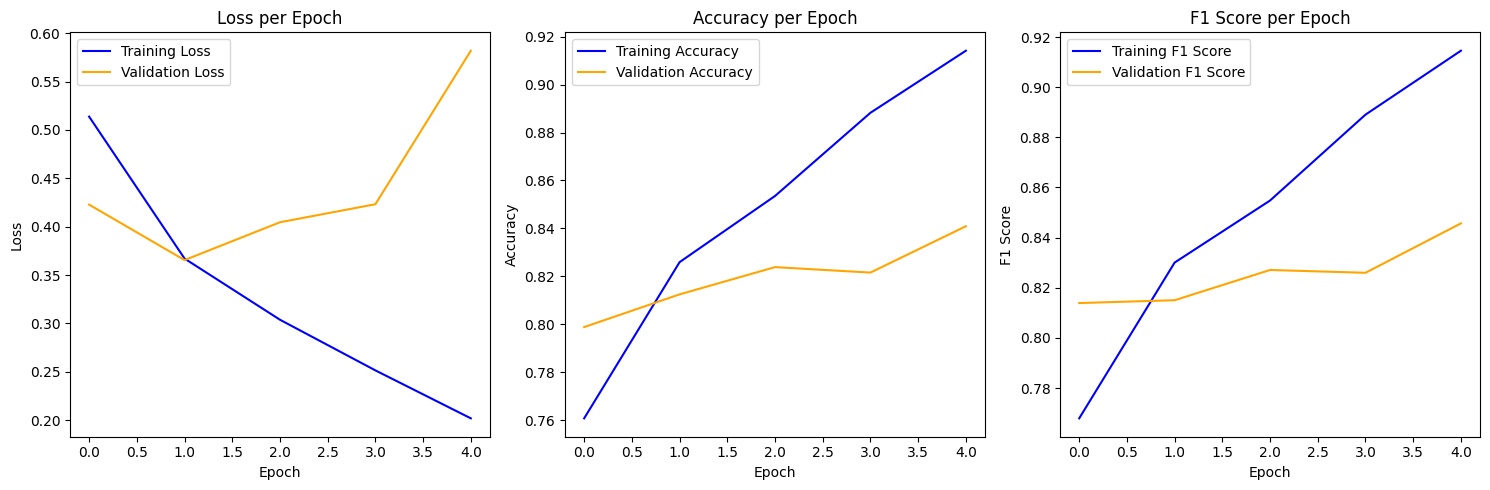

Results and graphs saved.


In [23]:
import matplotlib.pyplot as plt

# Plotting training and validation metrics
plt.figure(figsize=(15, 5))

# Plotting training and validation loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation F1 score
plt.subplot(1, 3, 3)
plt.plot(train_f1_scores, label='Training F1 Score', color='blue')
plt.plot(val_f1_scores, label='Validation F1 Score', color='orange')
plt.title('F1 Score per Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()

# Save and show the plot
graphs_save_path = os.path.join(model_save_dir, 'training_graphs.png')
plt.savefig(graphs_save_path)
plt.show()

print("Results and graphs saved.")

# Fine-tuning RoBERTa

In [24]:
from transformers import RobertaTokenizer , AdamW , get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader , random_split
import torch

#train_data = subsampled_data

# Load tokenizer
tokenizer = RobertaTokenizer.from_pretrained("FacebookAI/roberta-base")

# Function to tokenize data
def tokenize_data(texts):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=128, return_tensors="pt")

# Tokenize the train and validation data
train_encodings = tokenize_data(train_data['comment'].tolist())
val_encodings = tokenize_data(val_data['comment'].tolist())

# Create labels tensors
train_labels = torch.tensor(train_data['isToxic'].values)
val_labels = torch.tensor(val_data['isToxic'].values)

# Create TensorDatasets for train and validation sets
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)

c:\Users\Family-PC\miniconda3\envs\thesis\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [25]:
# Create DataLoaders
batch_size = 16  # Adjust based on your GPU memory
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
    pin_memory=True
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8,
    pin_memory=True
)

In [26]:
from transformers import RobertaForSequenceClassification
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import time

# Load model
model = RobertaForSequenceClassification.from_pretrained("models/Experiments/Experiments_with_Cross_Validation/Experiment-1/RoBERTa_ENGLISHDATASET", num_labels=1)
model.to(device)

# Initialize optimizer, loss, and scaler
learning_rate = 2e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.BCEWithLogitsLoss()
scaler = torch.cuda.amp.GradScaler()

c:\Users\Family-PC\miniconda3\envs\thesis\lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [27]:
# Early stopping parameters
early_stopping_patience = 3
best_val_loss = float('inf')
best_epoch = 0
early_stopping_counter = 0

# Training parameters
num_epochs = 20
total_batches = len(train_dataloader)
print_every = total_batches // 10

# Training loop
model.train()
epoch_times = []

# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_f1_scores = []
val_f1_scores = []
train_precisions = []
val_precisions = []
train_recalls = []
val_recalls = []

# Scheduler: Linear warmup and decay
num_training_steps = num_epochs * len(train_dataloader)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Create directory to save the best model
model_save_dir = '../../temp/'
os.makedirs(model_save_dir, exist_ok=True)
best_model_path = os.path.join(model_save_dir, 'best_model.pth')

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    running_loss = 0.0
    all_predictions = []
    all_targets = []

    for batch_idx, (input_ids, attention_mask, target) in enumerate(train_dataloader):
        input_ids, attention_mask, target = input_ids.to(device), attention_mask.to(device), target.to(device)
        
        target = target.unsqueeze(1).float()
        optimizer.zero_grad()
        
        with autocast():
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, target)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        running_loss += loss.item()

        preds = torch.sigmoid(outputs.logits).detach().cpu().numpy()
        preds = (preds > 0.5).astype(int)
        all_predictions.extend(preds)
        all_targets.extend(target.detach().cpu().numpy())

        if batch_idx % print_every == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx+1}/{total_batches}: Loss: {loss.item():.4f}")

    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)

    epoch_loss = running_loss / total_batches
    epoch_accuracy = accuracy_score(np.vstack(all_predictions), np.vstack(all_targets))
    epoch_f1 = f1_score(np.vstack(all_predictions), np.vstack(all_targets), average='weighted')
    epoch_precision = precision_score(np.vstack(all_predictions), np.vstack(all_targets), average='weighted')
    epoch_recall = recall_score(np.vstack(all_predictions), np.vstack(all_targets), average='weighted')

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    train_f1_scores.append(epoch_f1)
    train_precisions.append(epoch_precision)
    train_recalls.append(epoch_recall)

    # Validation step
    model.eval()
    val_loss = 0.0
    val_predictions = []
    val_targets = []

    with torch.no_grad():
        for input_ids, attention_mask, target in val_dataloader:
            input_ids, attention_mask, target = input_ids.to(device), attention_mask.to(device), target.to(device)

            target = target.unsqueeze(1).float()

            with autocast():
                outputs = model(input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.logits, target)

            val_loss += loss.item()

            preds = torch.sigmoid(outputs.logits).detach().cpu().numpy()
            preds = (preds > 0.5).astype(int)
            val_predictions.extend(preds)
            val_targets.extend(target.detach().cpu().numpy())

    val_loss /= len(val_dataloader)
    val_accuracy = accuracy_score(np.vstack(val_predictions), np.vstack(val_targets))
    val_f1 = f1_score(np.vstack(val_predictions), np.vstack(val_targets), average='weighted')
    val_precision = precision_score(np.vstack(val_predictions), np.vstack(val_targets), average='weighted')
    val_recall = recall_score(np.vstack(val_predictions), np.vstack(val_targets), average='weighted')

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        early_stopping_counter = 0
        # Save the best model
        torch.save(model.state_dict(), best_model_path)
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

    # Switch back to training mode
    model.train()

    avg_epoch_time = sum(epoch_times) / len(epoch_times)
    estimated_total_time = avg_epoch_time * num_epochs
    remaining_time = estimated_total_time - sum(epoch_times)

    print(f"Epoch {epoch+1} completed in {epoch_time:.2f}s: Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, F1 Score: {epoch_f1:.4f}, Precision: {epoch_precision:.4f}, Recall: {epoch_recall:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation F1 Score: {val_f1:.4f}, Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}")
    print(f"Estimated total training time: {estimated_total_time:.2f}s")
    print(f"Estimated remaining time: {remaining_time:.2f}s")

print(f"Best epoch: {best_epoch + 1}, Best validation loss: {best_val_loss:.4f}")
print("Training completed.")

Epoch 1, Batch 1/220: Loss: 3.7255
Epoch 1, Batch 23/220: Loss: 0.7294
Epoch 1, Batch 45/220: Loss: 0.6638
Epoch 1, Batch 67/220: Loss: 0.5834
Epoch 1, Batch 89/220: Loss: 0.8922
Epoch 1, Batch 111/220: Loss: 0.2191
Epoch 1, Batch 133/220: Loss: 0.4620
Epoch 1, Batch 155/220: Loss: 0.6173
Epoch 1, Batch 177/220: Loss: 0.4232
Epoch 1, Batch 199/220: Loss: 0.4140
Epoch 1 completed in 42.03s: Loss: 0.5428, Accuracy: 0.7426, F1 Score: 0.7570, Precision: 0.7996, Recall: 0.7426
Validation Loss: 0.4298, Validation Accuracy: 0.7875, Validation F1 Score: 0.7957, Validation Precision: 0.8252, Validation Recall: 0.7875
Estimated total training time: 840.68s
Estimated remaining time: 798.64s
Epoch 2, Batch 1/220: Loss: 0.3967
Epoch 2, Batch 23/220: Loss: 0.3664
Epoch 2, Batch 45/220: Loss: 0.3753
Epoch 2, Batch 67/220: Loss: 0.4908
Epoch 2, Batch 89/220: Loss: 0.2136
Epoch 2, Batch 111/220: Loss: 0.5383
Epoch 2, Batch 133/220: Loss: 0.2469
Epoch 2, Batch 155/220: Loss: 0.3604
Epoch 2, Batch 177/22

In [28]:
import csv

# Save the trained model
model_save_dir = 'models/Experiments/Experiments_with_Cross_Validation/Experiment-2/RoBERTa_FINETUNE/'
os.makedirs(model_save_dir, exist_ok=True)
model.save_pretrained(model_save_dir)

# Save metrics to a CSV file
metrics_dict = {
    'Epoch': list(range(1, epoch + 2)),
    'Train Loss': train_losses,
    'Train Accuracy': train_accuracies,
    'Train F1 Score': train_f1_scores,
    'Train Precision': train_precisions,
    'Train Recall': train_recalls,
    'Val Loss': val_losses,
    'Val Accuracy': val_accuracies,
    'Val F1 Score': val_f1_scores,
    'Val Precision': val_precisions,
    'Val Recall': val_recalls
}

metrics_filename = os.path.join(model_save_dir, 'metrics.csv')
with open(metrics_filename, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=metrics_dict.keys())
    writer.writeheader()
    for row_idx in range(len(train_losses)):
        writer.writerow({key: metrics_dict[key][row_idx] for key in metrics_dict.keys()})

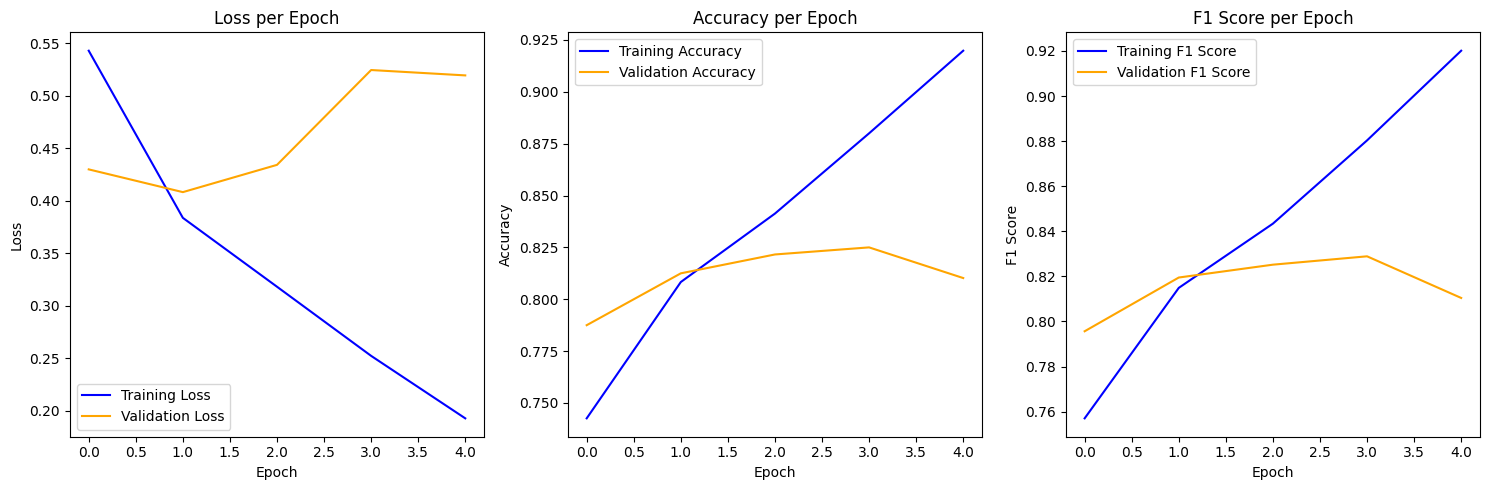

Results and graphs saved.


In [29]:
import matplotlib.pyplot as plt

# Plotting training and validation metrics
plt.figure(figsize=(15, 5))

# Plotting training and validation loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation F1 score
plt.subplot(1, 3, 3)
plt.plot(train_f1_scores, label='Training F1 Score', color='blue')
plt.plot(val_f1_scores, label='Validation F1 Score', color='orange')
plt.title('F1 Score per Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()

# Save and show the plot
graphs_save_path = os.path.join(model_save_dir, 'training_graphs.png')
plt.savefig(graphs_save_path)
plt.show()

print("Results and graphs saved.")